# Imports

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR , CosineAnnealingLR
from torch.utils.data import random_split, ConcatDataset

# Data Loading

In [ ]:
train_size = 49000
val_size =  9800
test_size = 21000
batch_size=512
random_seed = 42
torch.cuda.is_available()

False

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
full_DS = ConcatDataset([dataset,testset])

torch.manual_seed(random_seed);
train_ds, testset = random_split(full_DS, [train_size, test_size])
train_ds, val_ds = random_split(train_ds, [train_size-val_size, val_size])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
len(train_ds), len(val_ds), len(testset)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(39200, 9800, 21000)

# Model

In [ ]:

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class Mlp(ImageClassificationBase):
    def __init__(self):
        super(Mlp,self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,10)
        # self.droput = nn.Dropout(0.2)
        
    def forward(self,x):
        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)


# Helper Functions

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(question_no,epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD,momentum=None,scheduler=None):
    history = []
    if momentum == None:
        optimizer = opt_func(model.parameters(), lr)
    else:
        optimizer = opt_func(model.parameters(), lr,momentum=momentum)
    
    if scheduler == "CosineAnnealingLR":
        scheduler = CosineAnnealingLR(optimizer, len(train_loader), verbose = False)
    elif scheduler == "StepLR":
        scheduler = StepLR(optimizer, step_size=1000, gamma=0.8)
    val_accuracy = 0
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            if scheduler != None:
                scheduler.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        # print(history)
        if (val_accuracy < history[-1]["val_acc"]):
            torch.save(model.state_dict(), question_no)
            print("saving model for", question_no)
            val_accuracy = history[-1]["val_acc"]
    return history
def test_accuracy(model, test_loader):
    result = evaluate(model, test_loader)    
    return result["val_acc"]

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)


# Part 1

## Adam


In [ ]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
model1 = to_device(Mlp(), device);
history1 = fit("part1",num_epochs, lr, model1, train_dl, val_dl, opt_func,scheduler="StepLR")


Epoch [0], train_loss: 0.7595, val_loss: 0.3244, val_acc: 0.9047
saving model for part1
Epoch [1], train_loss: 0.2621, val_loss: 0.2442, val_acc: 0.9284
saving model for part1
Epoch [2], train_loss: 0.2010, val_loss: 0.2034, val_acc: 0.9388
saving model for part1
Epoch [3], train_loss: 0.1587, val_loss: 0.1748, val_acc: 0.9462
saving model for part1
Epoch [4], train_loss: 0.1317, val_loss: 0.1505, val_acc: 0.9550
saving model for part1
Epoch [5], train_loss: 0.1118, val_loss: 0.1321, val_acc: 0.9600
saving model for part1
Epoch [6], train_loss: 0.0914, val_loss: 0.1283, val_acc: 0.9609
saving model for part1
Epoch [7], train_loss: 0.0766, val_loss: 0.1180, val_acc: 0.9631
saving model for part1
Epoch [8], train_loss: 0.0652, val_loss: 0.1158, val_acc: 0.9647
saving model for part1
Epoch [9], train_loss: 0.0582, val_loss: 0.1089, val_acc: 0.9661
saving model for part1
Epoch [10], train_loss: 0.0499, val_loss: 0.1010, val_acc: 0.9692
saving model for part1
Epoch [11], train_loss: 0.0400,

In [ ]:
model1.load_state_dict(torch.load("part1"))
print("accuracy for part 1 = ", test_accuracy(model1,test_dl)*100,"%")

accuracy for part 1 =  97.4142849445343 %


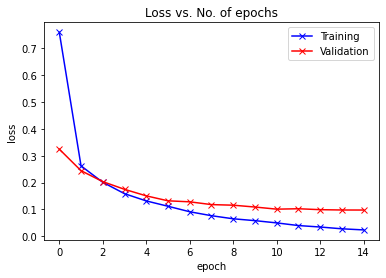

In [ ]:

plot_losses(history1)

## RMS

In [ ]:
num_epochs = 15
opt_func = torch.optim.RMSprop
lr = 0.001

In [ ]:
model2 = to_device(Mlp(), device);
history2 = fit("part2",num_epochs, lr, model2, train_dl, val_dl, opt_func,scheduler="StepLR")


Epoch [0], train_loss: 0.7357, val_loss: 0.3220, val_acc: 0.9085
saving model for part2
Epoch [1], train_loss: 0.2612, val_loss: 0.2408, val_acc: 0.9300
saving model for part2
Epoch [2], train_loss: 0.1971, val_loss: 0.2068, val_acc: 0.9384
saving model for part2
Epoch [3], train_loss: 0.1568, val_loss: 0.1644, val_acc: 0.9499
saving model for part2
Epoch [4], train_loss: 0.1288, val_loss: 0.1489, val_acc: 0.9552
saving model for part2
Epoch [5], train_loss: 0.1061, val_loss: 0.1361, val_acc: 0.9582
saving model for part2
Epoch [6], train_loss: 0.0902, val_loss: 0.1275, val_acc: 0.9618
saving model for part2
Epoch [7], train_loss: 0.0749, val_loss: 0.1145, val_acc: 0.9655
saving model for part2
Epoch [8], train_loss: 0.0641, val_loss: 0.1076, val_acc: 0.9685
saving model for part2
Epoch [9], train_loss: 0.0541, val_loss: 0.1048, val_acc: 0.9691
saving model for part2
Epoch [10], train_loss: 0.0442, val_loss: 0.1014, val_acc: 0.9689
Epoch [11], train_loss: 0.0386, val_loss: 0.0968, val_

In [ ]:
model2.load_state_dict(torch.load("part2"))
print("accuracy for part 2 = ", test_accuracy(model2,test_dl)*100,"%")

accuracy for part 2 =  97.45714068412781 %


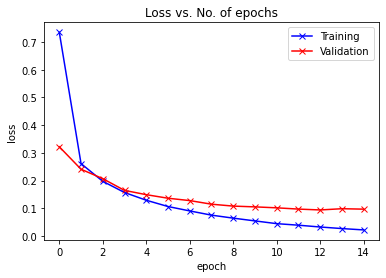

In [ ]:

plot_losses(history2)

## SGD

In [ ]:
num_epochs = 15
opt_func = torch.optim.SGD
lr = 0.05

In [ ]:
model3 = to_device(Mlp(), device);
history3 = fit("part3",num_epochs, lr, model3, train_dl, val_dl, opt_func,scheduler="StepLR")


Epoch [0], train_loss: 2.2065, val_loss: 2.0087, val_acc: 0.5659
saving model for part3
Epoch [1], train_loss: 1.5078, val_loss: 0.9989, val_acc: 0.7600
saving model for part3
Epoch [2], train_loss: 0.7683, val_loss: 0.6153, val_acc: 0.8422
saving model for part3
Epoch [3], train_loss: 0.5391, val_loss: 0.4856, val_acc: 0.8694
saving model for part3
Epoch [4], train_loss: 0.4489, val_loss: 0.4263, val_acc: 0.8817
saving model for part3
Epoch [5], train_loss: 0.4012, val_loss: 0.3945, val_acc: 0.8893
saving model for part3
Epoch [6], train_loss: 0.3715, val_loss: 0.3708, val_acc: 0.8951
saving model for part3
Epoch [7], train_loss: 0.3503, val_loss: 0.3543, val_acc: 0.8996
saving model for part3
Epoch [8], train_loss: 0.3346, val_loss: 0.3435, val_acc: 0.9039
saving model for part3
Epoch [9], train_loss: 0.3205, val_loss: 0.3316, val_acc: 0.9058
saving model for part3
Epoch [10], train_loss: 0.3088, val_loss: 0.3199, val_acc: 0.9120
saving model for part3
Epoch [11], train_loss: 0.2976,

In [ ]:
model3.load_state_dict(torch.load("part3"))
print("accuracy for part 3 = ", test_accuracy(model3,test_dl)*100,"%")

accuracy for part 3 =  92.01428294181824 %


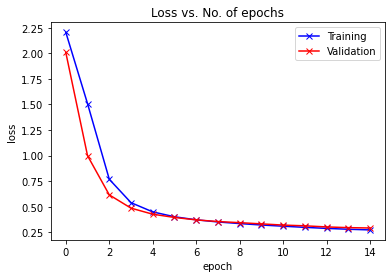

In [ ]:

plot_losses(history3)

## SGD with Momentum


In [ ]:
num_epochs = 15
opt_func = torch.optim.SGD
lr = 0.05
momentum = 0.9

In [ ]:
model4 = to_device(Mlp(), device);
history4 = fit("part4",num_epochs, lr, model4, train_dl, val_dl, opt_func,momentum)


Epoch [0], train_loss: 1.1610, val_loss: 0.3878, val_acc: 0.8881
saving model for part4
Epoch [1], train_loss: 0.3217, val_loss: 0.2943, val_acc: 0.9156
saving model for part4
Epoch [2], train_loss: 0.2417, val_loss: 0.2381, val_acc: 0.9290
saving model for part4
Epoch [3], train_loss: 0.1963, val_loss: 0.2049, val_acc: 0.9391
saving model for part4
Epoch [4], train_loss: 0.1599, val_loss: 0.1675, val_acc: 0.9479
saving model for part4
Epoch [5], train_loss: 0.1326, val_loss: 0.1529, val_acc: 0.9550
saving model for part4
Epoch [6], train_loss: 0.1121, val_loss: 0.1350, val_acc: 0.9598
saving model for part4
Epoch [7], train_loss: 0.0947, val_loss: 0.1291, val_acc: 0.9604
saving model for part4
Epoch [8], train_loss: 0.0823, val_loss: 0.1180, val_acc: 0.9636
saving model for part4
Epoch [9], train_loss: 0.0739, val_loss: 0.1156, val_acc: 0.9662
saving model for part4
Epoch [10], train_loss: 0.0649, val_loss: 0.1121, val_acc: 0.9661
Epoch [11], train_loss: 0.0547, val_loss: 0.1045, val_

In [ ]:
model4.load_state_dict(torch.load("part4"))
print("accuracy for part 4 = ", test_accuracy(model4,test_dl)*100,"%")

accuracy for part 4 =  97.39999771118164 %


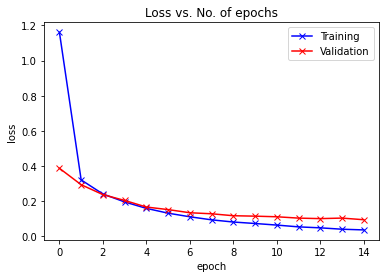

In [ ]:

plot_losses(history4)

## Xavier Weight Iniatialisation(Normal)

In [ ]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
model5 = to_device(Mlp(), device);
x = list(model5.parameters())
nn.init.xavier_normal_(x[0], gain=nn.init.calculate_gain('relu'))
history5 = fit("part5",num_epochs, lr, model5, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.7286, val_loss: 0.3138, val_acc: 0.9108
saving model for part5
Epoch [1], train_loss: 0.2494, val_loss: 0.2331, val_acc: 0.9314
saving model for part5
Epoch [2], train_loss: 0.1835, val_loss: 0.1865, val_acc: 0.9450
saving model for part5
Epoch [3], train_loss: 0.1450, val_loss: 0.1558, val_acc: 0.9527
saving model for part5
Epoch [4], train_loss: 0.1163, val_loss: 0.1423, val_acc: 0.9579
saving model for part5
Epoch [5], train_loss: 0.0974, val_loss: 0.1232, val_acc: 0.9639
saving model for part5
Epoch [6], train_loss: 0.0790, val_loss: 0.1207, val_acc: 0.9655
saving model for part5
Epoch [7], train_loss: 0.0666, val_loss: 0.1099, val_acc: 0.9677
saving model for part5
Epoch [8], train_loss: 0.0554, val_loss: 0.1042, val_acc: 0.9699
saving model for part5
Epoch [9], train_loss: 0.0463, val_loss: 0.1012, val_acc: 0.9710
saving model for part5
Epoch [10], train_loss: 0.0382, val_loss: 0.0965, val_acc: 0.9733
saving model for part5
Epoch [11], train_loss: 0.0325,

In [ ]:
model5.load_state_dict(torch.load("part5"))
print("accuracy for part 5 = ", test_accuracy(model5,test_dl)*100,"%")

accuracy for part 5 =  97.47142791748047 %


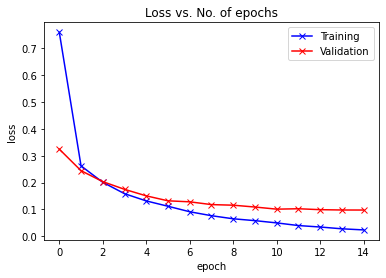

In [ ]:

plot_losses(history1)

### Xavier Weight Iniatialisation (Uniform)

In [ ]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
model6 = to_device(Mlp(), device);
x = list(model6.parameters())
nn.init.xavier_uniform_(x[0], gain=nn.init.calculate_gain('relu'))
history6 = fit("part6",num_epochs, lr, model6, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.7177, val_loss: 0.3160, val_acc: 0.9093
saving model for part6
Epoch [1], train_loss: 0.2591, val_loss: 0.2448, val_acc: 0.9299
saving model for part6
Epoch [2], train_loss: 0.1939, val_loss: 0.1932, val_acc: 0.9442
saving model for part6
Epoch [3], train_loss: 0.1517, val_loss: 0.1670, val_acc: 0.9491
saving model for part6
Epoch [4], train_loss: 0.1236, val_loss: 0.1473, val_acc: 0.9550
saving model for part6
Epoch [5], train_loss: 0.1042, val_loss: 0.1308, val_acc: 0.9629
saving model for part6
Epoch [6], train_loss: 0.0850, val_loss: 0.1204, val_acc: 0.9657
saving model for part6
Epoch [7], train_loss: 0.0716, val_loss: 0.1176, val_acc: 0.9667
saving model for part6
Epoch [8], train_loss: 0.0605, val_loss: 0.1098, val_acc: 0.9672
saving model for part6
Epoch [9], train_loss: 0.0503, val_loss: 0.1033, val_acc: 0.9696
saving model for part6
Epoch [10], train_loss: 0.0429, val_loss: 0.1043, val_acc: 0.9701
saving model for part6
Epoch [11], train_loss: 0.0345,

In [ ]:
model6.load_state_dict(torch.load("part6"))
print("accuracy for part 6 = ", test_accuracy(model6,test_dl)*100,"%")

accuracy for part 6 =  97.47142791748047 %


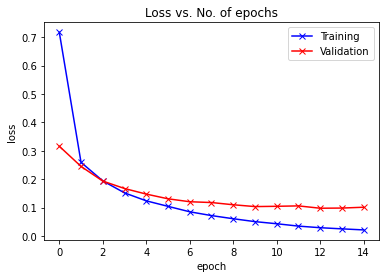

In [ ]:

plot_losses(history6)

### Uniform Weight Initialisation

In [ ]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
model7 = to_device(Mlp(), device);
x = list(model7.parameters())
nn.init.uniform_(x[0])
nn.init.uniform_(x[1])
history7 = fit("part7",num_epochs, lr, model7, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 5.0889, val_loss: 1.5301, val_acc: 0.5806
saving model for part7
Epoch [1], train_loss: 1.2441, val_loss: 1.0395, val_acc: 0.7421
saving model for part7
Epoch [2], train_loss: 0.8931, val_loss: 0.7758, val_acc: 0.8123
saving model for part7
Epoch [3], train_loss: 0.7061, val_loss: 0.6407, val_acc: 0.8356
saving model for part7
Epoch [4], train_loss: 0.5929, val_loss: 0.5579, val_acc: 0.8539
saving model for part7
Epoch [5], train_loss: 0.5311, val_loss: 0.4996, val_acc: 0.8659
saving model for part7
Epoch [6], train_loss: 0.4843, val_loss: 0.4913, val_acc: 0.8628
Epoch [7], train_loss: 0.4520, val_loss: 0.4432, val_acc: 0.8837
saving model for part7
Epoch [8], train_loss: 0.4128, val_loss: 0.4113, val_acc: 0.8877
saving model for part7
Epoch [9], train_loss: 0.4031, val_loss: 0.4140, val_acc: 0.8813
Epoch [10], train_loss: 0.3904, val_loss: 0.3936, val_acc: 0.8866
Epoch [11], train_loss: 0.3711, val_loss: 0.3910, val_acc: 0.8937
saving model for part7
Epoch [12],

In [ ]:
model7.load_state_dict(torch.load("part7"))
print("accuracy for part 7 = ", test_accuracy(model7,test_dl)*100,"%")

accuracy for part 7 =  90.45237898826599 %


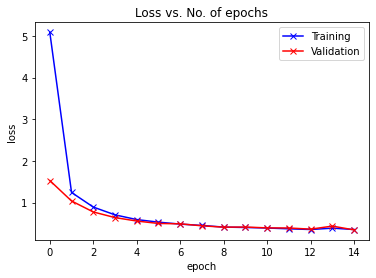

In [ ]:

plot_losses(history7)

### Normal Weight Initialisation

In [ ]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
model8 = to_device(Mlp(), device);
x = list(model8.parameters())
nn.init.normal_(x[0])
nn.init.normal_(x[1])
history8 = fit("part8",num_epochs, lr, model8, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.6729, val_loss: 0.3045, val_acc: 0.9125
saving model for part8
Epoch [1], train_loss: 0.2397, val_loss: 0.2345, val_acc: 0.9317
saving model for part8
Epoch [2], train_loss: 0.1778, val_loss: 0.1975, val_acc: 0.9401
saving model for part8
Epoch [3], train_loss: 0.1393, val_loss: 0.1723, val_acc: 0.9483
saving model for part8
Epoch [4], train_loss: 0.1128, val_loss: 0.1621, val_acc: 0.9512
saving model for part8
Epoch [5], train_loss: 0.0935, val_loss: 0.1464, val_acc: 0.9571
saving model for part8
Epoch [6], train_loss: 0.0776, val_loss: 0.1423, val_acc: 0.9591
saving model for part8
Epoch [7], train_loss: 0.0643, val_loss: 0.1360, val_acc: 0.9602
saving model for part8
Epoch [8], train_loss: 0.0542, val_loss: 0.1311, val_acc: 0.9604
saving model for part8
Epoch [9], train_loss: 0.0463, val_loss: 0.1333, val_acc: 0.9628
saving model for part8
Epoch [10], train_loss: 0.0374, val_loss: 0.1273, val_acc: 0.9635
saving model for part8
Epoch [11], train_loss: 0.0312,

In [ ]:
model8.load_state_dict(torch.load("part8"))
print("accuracy for part 8 = ", test_accuracy(model8,test_dl)*100,"%")

accuracy for part 8 =  96.79999947547913 %


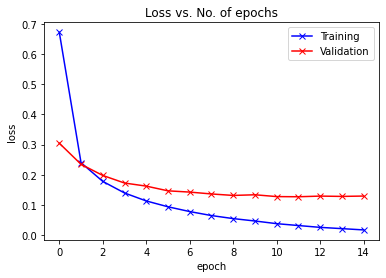

In [ ]:

plot_losses(history8)

### Exponential Annealing of learning rate

In [ ]:
num_epochs = 15
opt_func = torch.optim.Adam

lr = 0.001

In [ ]:
model9 = to_device(Mlp(), device);
x = list(model9.parameters())

history9 = fit("part9",num_epochs, lr, model9, train_dl, val_dl, opt_func,scheduler="CosineAnnealingLR")


Epoch [0], train_loss: 0.7908, val_loss: 0.4136, val_acc: 0.8867
saving model for part9
Epoch [1], train_loss: 0.3650, val_loss: 0.3182, val_acc: 0.9083
saving model for part9
Epoch [2], train_loss: 0.2561, val_loss: 0.2556, val_acc: 0.9269
saving model for part9
Epoch [3], train_loss: 0.2280, val_loss: 0.2368, val_acc: 0.9311
saving model for part9
Epoch [4], train_loss: 0.1910, val_loss: 0.2041, val_acc: 0.9401
saving model for part9
Epoch [5], train_loss: 0.1735, val_loss: 0.1921, val_acc: 0.9426
saving model for part9
Epoch [6], train_loss: 0.1496, val_loss: 0.1706, val_acc: 0.9505
saving model for part9
Epoch [7], train_loss: 0.1364, val_loss: 0.1766, val_acc: 0.9474
Epoch [8], train_loss: 0.1198, val_loss: 0.1468, val_acc: 0.9560
saving model for part9
Epoch [9], train_loss: 0.1085, val_loss: 0.1538, val_acc: 0.9542
Epoch [10], train_loss: 0.0994, val_loss: 0.1298, val_acc: 0.9619
saving model for part9
Epoch [11], train_loss: 0.0878, val_loss: 0.1316, val_acc: 0.9603
Epoch [12],

In [ ]:
model9.load_state_dict(torch.load("part9"))
print("accuracy for part 9 = ", test_accuracy(model9,test_dl)*100,"%")

accuracy for part 9 =  96.92857265472412 %


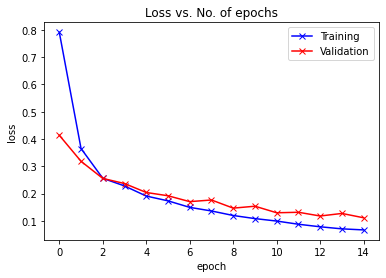

In [ ]:

plot_losses(history9)

#Part 2


## Autoencoder

In [ ]:
class Autoencoder128(ImageClassificationBase):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 64, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(64, 128, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,10)       
        )

    def forward(self, x):
        x = self.encoder(x)        
        x = self.classifier(x)
        return x

In [ ]:
num_epochs = 15
opt_func = torch.optim.Adam

lr = 0.001

In [ ]:
model10 = to_device(Autoencoder128(), device);


history10 = fit("part10",num_epochs, lr, model10, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.7322, val_loss: 0.2896, val_acc: 0.9133
saving model for part10
Epoch [1], train_loss: 0.2104, val_loss: 0.1650, val_acc: 0.9486
saving model for part10
Epoch [2], train_loss: 0.1171, val_loss: 0.1275, val_acc: 0.9596
saving model for part10
Epoch [3], train_loss: 0.0799, val_loss: 0.0835, val_acc: 0.9752
saving model for part10
Epoch [4], train_loss: 0.0617, val_loss: 0.0805, val_acc: 0.9760
saving model for part10
Epoch [5], train_loss: 0.0474, val_loss: 0.0731, val_acc: 0.9800
saving model for part10
Epoch [6], train_loss: 0.0412, val_loss: 0.0687, val_acc: 0.9796
Epoch [7], train_loss: 0.0320, val_loss: 0.0646, val_acc: 0.9807
saving model for part10
Epoch [8], train_loss: 0.0272, val_loss: 0.0720, val_acc: 0.9799
Epoch [9], train_loss: 0.0239, val_loss: 0.0738, val_acc: 0.9803
Epoch [10], train_loss: 0.0188, val_loss: 0.0683, val_acc: 0.9815
saving model for part10
Epoch [11], train_loss: 0.0187, val_loss: 0.0642, val_acc: 0.9831
saving model for part10
Ep

In [ ]:
model10.load_state_dict(torch.load("part10"))
print("accuracy for part 10 = ", test_accuracy(model10,test_dl)*100,"%")

accuracy for part 10 =  98.2714295387268 %


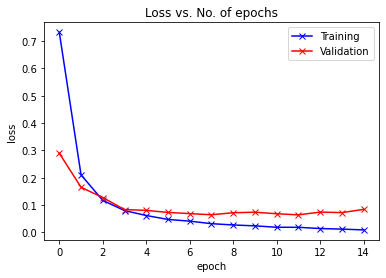

In [ ]:

plot_losses(history10)

In [ ]:
model2.load_state_dict(torch.load("part2"))
print("accuracy for RMS = ", test_accuracy(model2,test_dl)*100,"%")
print("accuracy for Auto Encoder feature learning = ", test_accuracy(model10,test_dl)*100,"%")

accuracy for RMS =  97.45714068412781 %
accuracy for Auto Encoder feature learning =  98.2714295387268 %
